# Pneumonia Classification with PyTorch

Pneumonia is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid or pus (purulent material), causing cough with phlegm or pus, fever, chills, and difficulty breathing. A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia. An early detection and treatment to prevent progression might be crucial due to its fatality rate, which is 5 to 10 percent for hospitalized patients.

This study aims to provide one classification model and one detection model for pneumonia by evaluating the X-Ray images provided in the (pneumonia detection challenge)[https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/] in Kaggle. Further information regarding the dataset can be found in the (*ChestX-ray8*)[https://arxiv.org/abs/1705.02315] paper.

## Importing Libraries

In [1]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 59.3 MB/s eta 0:00:00


In [2]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 26.7 MB/s eta 0:00:00


In [3]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.6/715.6 KB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 21.1 MB/s eta 0:00:00


In [4]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
!mkdir ~/.kaggle

In [7]:
!cp /content/drive/MyDrive/Colab_Notebooks/Kaggle_API/kaggle.json ~/.kaggle/kaggle.json

In [8]:
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle competitions download rsna-pneumonia-detection-challenge

100% 3.66G/3.66G [02:49<00:00, 22.9MB/s]
100% 3.66G/3.66G [02:49<00:00, 23.2MB/s]


In [10]:
!unzip rsna-pneumonia-detection-challenge.zip

Streaming output truncated to the last 5000 lines.
  inflating: stage_2_train_images/d5231546-354e-4071-9af1-6644beabfd86.dcm  
  inflating: stage_2_train_images/d5252a78-3ea1-48e9-9ffb-e7535be3ce80.dcm  
  inflating: stage_2_train_images/d525eafb-8908-45fd-a942-48d07c435487.dcm  
  inflating: stage_2_train_images/d5265640-17db-4880-866d-d2952e32941c.dcm  
  inflating: stage_2_train_images/d5277276-f8f8-40e9-b8e1-791cf5d96ac0.dcm  
  inflating: stage_2_train_images/d528d9e9-647a-4e2e-a16c-bd5e32a5bbf5.dcm  
  inflating: stage_2_train_images/d5293a3e-f050-4b98-8bbf-1f40e25bced5.dcm  
  inflating: stage_2_train_images/d52cbb5a-1d0a-457d-8c72-0f7aeec21ca7.dcm  
  inflating: stage_2_train_images/d52ce67b-be7c-4349-8dc4-38562928d208.dcm  
  inflating: stage_2_train_images/d535a3c8-c4a4-4856-b5cd-17f6332eac8b.dcm  
  inflating: stage_2_train_images/d5360dc4-6bea-4a7b-bc49-5b2547ad7877.dcm  
  inflating: stage_2_train_images/d5364bc1-bc2a-4bd0-a1bd-0cfb5a369ccc.dcm  
  inflating: stage_2_trai

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pydicom  # To read dicom files
# Modeling --------------------------
import torch
import torchvision
from torchvision import transforms  # For data augmentation & normalization
import torchmetrics # Easy metric computation
import pytorch_lightning as pl  
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
# -----------------------------------
from pathlib import Path    # For file path handling
import cv2  # For image resizing
from tqdm.notebook import tqdm  # For progress bar
import os

## Preprocessing and Loading the Data

In [12]:
# Reading the data labels

labels = pd.read_csv("stage_2_train_labels.csv")
labels.head(10)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


The data includes 6 columns including patient ID, target variable, and information about the location of the pneumonia if it exists. Notice that there are multiple entries for some patients since pneumonia can be located at more than one segment of an X-Ray image. A subset of the dataset such that each patient has only one record is sufficient in this case since the aim of this study is not detection.

In [13]:
# Dropping the duplicate rows based on patient ID

labels = labels.drop_duplicates("patientId")

In [14]:
# Defining import and export paths

ROOT_PATH = Path("stage_2_train_images/")
SAVE_PATH = Path("Processed/")

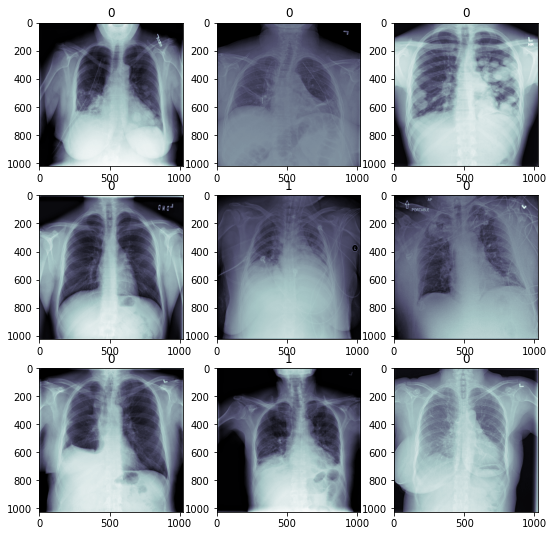

In [15]:
# Writing a nested loop to read and visualize a sample from the dataset

fig, axis = plt.subplots(3, 3, figsize = (9, 9))
plt.subplots_adjust(top=1)

c = 0

for i in range(3):
    for j in range(3):
        
        # Load image
        patient_id = labels.patientId.iloc[c]
        dcm_path = ROOT_PATH/patient_id
        dcm_path = dcm_path.with_suffix(".dcm")
        dcm = pydicom.read_file(dcm_path).pixel_array
        
        # Print image
        label = labels["Target"].iloc[c]
        
        axis[i][j].imshow(dcm, cmap="bone")
        axis[i][j].set_title(label)
        
        c += 1

In [16]:
len_train = len(os.listdir(ROOT_PATH))
len_valid = len(os.listdir("stage_2_test_images/"))
print(len_train)
print(len_valid)

26684
3000


In [17]:
# Resizing the images for an easy training
# Standardazing the pixel values by dividing by 255 
# Using tqdm to track the loading progress

sums, sums_squared = 0, 0

for c, patient_id in enumerate(tqdm(labels.patientId)):
    
    # Load image
    patient_id = labels.patientId.iloc[c]
    dcm_path = ROOT_PATH/patient_id
    dcm_path = dcm_path.with_suffix(".dcm")
    dcm = pydicom.read_file(dcm_path).pixel_array / 255  
    
    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)
    
    label = labels.Target.iloc[c]

    # Splitting the data into training and test

    train_or_test = "train" if c < 24000 else "test" 
        
    current_save_path = SAVE_PATH/train_or_test/str(label)
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(current_save_path/patient_id, dcm_array)
    
    normalizer = 224 * 224
    if train_or_test == "train":
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (np.power(dcm_array, 2).sum()) / normalizer

  0%|          | 0/26684 [00:00<?, ?it/s]

In [18]:
# Defining and checking the mean and the standard deviation

mean = sums / len_train
stdev = np.sqrt(sums_squared / len_train - (mean**2))
print(f"Mean:\t\t\t {mean} \nStandard Deviation:\t {stdev}")

Mean:			 0.44106992823128194 
Standard Deviation:	 0.27758244159100576


In [19]:
# Function to load data

def load_file(path):
    return(np.load(path).astype(np.float32))

The following cells perform random augmentations  on the dataset such as crops, rotations etc. to make the model more powerful in assessing low-quality images.

In [20]:
# Data Augmentation Settings

train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean, stdev),
                                       transforms.RandomAffine(degrees     = (-5, 5),
                                                               translate   = (0, 0.05),
                                                               scale       = (0.9, 1.1)),
                                       transforms.RandomResizedCrop((224, 224),
                                                                    scale = (0.35, 1))
                                        ])

test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, stdev),
                                        ])

In [21]:
# Defining the train and test data

train = torchvision.datasets.DatasetFolder("Processed/train/",
                                           loader = load_file,
                                           extensions = "npy",
                                           transform = train_transforms)

test = torchvision.datasets.DatasetFolder("Processed/test/",
                                          loader = load_file,
                                          extensions = "npy",
                                          transform = test_transforms)

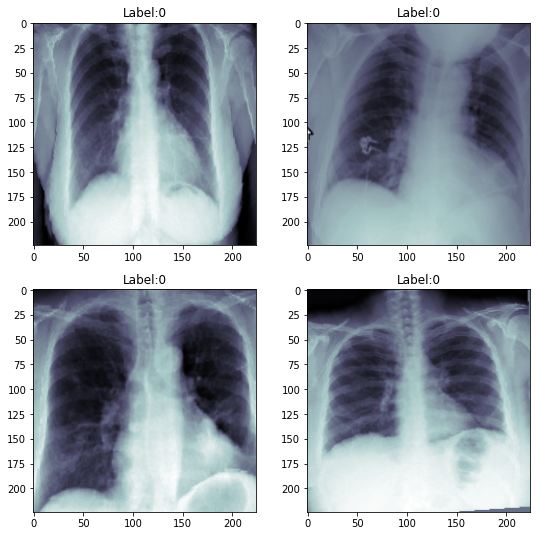

In [22]:
# Viewing a random sample of 4

fig, axis = plt.subplots(2, 2, figsize = (9, 9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 24000)
        x_ray, label = train[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(f"Label:{label}")

The effect of augmentation can be seen clearly.

In [23]:
batch_size = 64
num_workers = 2

train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, num_workers = num_workers, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, num_workers = num_workers, shuffle = False)

print(f"# of train images: \t{len(train)} \n# of test images: \t{len(test)}")

# of train images: 	24000 
# of test images: 	2684


In [24]:
# Checking the number of images with and without pneumonia in the train set

np.unique(train.targets, return_counts = True)

(array([0, 1]), array([18593,  5407]))

Since the data is imbalanced and the number of images without pneumonia are almost 3 times higher than images with pneumonia, a *weighted loss* of 3 can be used in the model, which means that the model will assign a higher penalty for the misclassification of the negative class.

## Modeling



In [25]:
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
class PneumoniaClassifier(pl.LightningModule):
    
    def __init__(self):

        super().__init__()
        
        self.model = torchvision.models.resnet18()
        # modifying the input channels of the first convolutional layer (conv1) from 3 to 1
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # modifying the out_features of the last fully connected layer (fc) from 1000 to 1
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        # Adding the weigted loss to overcome the imbalance in the dataset
        self.loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]))
        
        # Tracking the train and validation accuracy
        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.valid_acc = torchmetrics.Accuracy(task="binary")

        # ---
        self.training_step_outputs = []
        self.validation_step_outputs = []

    def forward(self, data):
        # Computes the output of ResNet-18 and returns the prediction
        pred = self.model(data)
        return(pred)
    
    def training_step(self, batch, batch_idx):
        # PyTorch lightning optimizes according to the value returned by this function

        # Calculating the loss
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]
        loss = self.loss_func(pred, label)

        # ---
        self.training_step_outputs.append(loss)
        
        # Recording accuracy
        self.log("Train Loss", loss)
        self.log("Step Train Acc", self.train_acc(torch.sigmoid(pred), label.int()))    # Converted to probability w/Sigmoid
        return(loss)
    
    def on_train_epoch_end(self):
        epoch_average = torch.stack(self.training_step_outputs).mean()
        self.log("training_epoch_average", epoch_average)
        self.training_step_outputs.clear()  # free memory
        
        
    def validation_step(self, batch, batch_idx):
        
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]
        loss = self.loss_func(pred, label)
        
        # ---
        self.validation_step_outputs.append(loss)

        self.log("Validation Loss", loss)
        self.log("Step Validation Acc", self.valid_acc(torch.sigmoid(pred), label.int()))
        return(loss)
    
    def on_validation_epoch_end(self):
         epoch_average = torch.stack(self.validation_step_outputs).mean()
         self.log("validation_epoch_average", epoch_average)
         self.validation_step_outputs.clear()  # free memory
    
    def configure_optimizers(self):
        return([self.optimizer])

In [27]:
model = PneumoniaClassifier()

In [28]:
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
available_gpus

In [29]:
# Model checkpoint: Save top 10 checkpoints based on the highest validation accuracy

checkpoint_callback = ModelCheckpoint(monitor = 'Step Validation Acc',
                                      save_top_k = 10,
                                      mode = 'max')

# Creating the trainer

trainer = pl.Trainer(accelerator = "gpu", 
                     logger = TensorBoardLogger(save_dir= "./logs"), 
                     log_every_n_steps = 1,
                     callbacks = checkpoint_callback,
                     max_epochs = 40)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [30]:
trainer.fit(model, train_loader, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 11.2 M
1 | loss_func | BCEWithLogitsLoss | 0     
2 | train_acc | BinaryAccuracy    | 0     
3 | valid_acc | BinaryAccuracy    | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


## Validation

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# model = PneumoniaClassifier.load_from_checkpoint("weights/weights_3.ckpt")
model.eval()
model.to(device)

PneumoniaClassifier(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [32]:
# Calculating predictions

preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(test):
        data = data.to(device).float().unsqueeze(0)
        
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/2684 [00:00<?, ?it/s]

In [33]:
# Checking the metrics

acc = torchmetrics.Accuracy(task="binary")(preds, labels)
precision = torchmetrics.Precision(task="binary")(preds, labels)
recall = torchmetrics.Recall(task="binary")(preds, labels)
cm = torchmetrics.ConfusionMatrix(task="binary")(preds, labels)

print(f"Accuracy:\t\t{acc}")
print(f"Precision:\t\t{precision}")
print(f"Recall:\t\t\t{recall}")
print(f"Confusion Matrix:\n {cm}")

Accuracy:		0.8036512732505798
Precision:		0.5432372689247131
Recall:			0.8099173307418823
Confusion Matrix:
 tensor([[1667,  412],
        [ 115,  490]])


High recall points out that the model rarely misses the cases with pneumonia, yet the precision score is not that good and points out the high number of false positives. In this context, the model's performance can be considered good since missing a pneumonia case is worse than predicting a false positive.

For lower maximum number of epochs, the model would yield a better accuracy and worse recall, yet a better recall and a sufficient accuracy is obviously better. Therefore, it can be concluded that setting the penalty weight to 3 contributed well, as the model gets closer to the optimum with higher epochs.